In [13]:
from src.io_utils import load_data, coerce_numeric

df = coerce_numeric(load_data("data/library_loans.csv"))

# Removes rows with missing or non-positive loan days
df = df.dropna(subset=["loan_days"]).copy()
df = df[df["loan_days"] > 0].copy()

df["month"] = df["checkout_date"].dt.to_period("M").dt.to_timestamp()
df["week"] = df["checkout_date"].dt.to_period("W").dt.start_time

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 0 to 127
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   loan_id           124 non-null    object        
 1   checkout_date     124 non-null    datetime64[ns]
 2   branch            121 non-null    object        
 3   genre             118 non-null    object        
 4   item_type         123 non-null    object        
 5   patron_age_group  123 non-null    object        
 6   loan_days         124 non-null    int64         
 7   returned_date     108 non-null    datetime64[ns]
 8   overdue_days      114 non-null    float64       
 9   fine_amount       113 non-null    float64       
 10  month             124 non-null    datetime64[ns]
 11  week              124 non-null    datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(1), object(5)
memory usage: 12.6+ KB


,loan_id,checkout_date,branch,genre,item_type,patron_age_group,loan_days,returned_date,overdue_days,fine_amount,month,week
0,L0005,2025-08-05,Väster,Romantik,E-bok,Vuxen,18,2025-08-23,0.0,NaN,2025-08-01,2025-08-04
1,L0041,2025-08-30,Öster,Biografi,Tidskrift,Vuxen,23,2025-09-22,1.0,2.935475,2025-08-01,2025-08-25
2,L0091,2025-03-19,Väster,Biografi,E-bok,Vuxen,23,2025-04-11,2.0,13.479296,2025-03-01,2025-03-17
3,L0083,2025-06-12,Öster,Fakta,Tidskrift,Vuxen,21,2025-07-03,0.0,0.000000,2025-06-01,2025-06-09
4,L0043,2025-08-09,Söder,Biografi,Ljudbok,Vuxen,23,2025-09-01,1.0,6.428793,2025-08-01,2025-08-04


In [14]:
from src import metrics as M

print("Total loans:", M.total_loans(df))
print(f"Average loan days: {M.average_loan_days(df):.1f}")
print(f"Overdue rate: {100.0 * M.overdue_rate(df):.1f}%")

Total loans: 116
Average loan days: 21.3
Overdue rate: 47.6%


In [15]:
by_genre = M.loans_by_genre(df)
by_branch = M.loans_by_branch(df)
by_genre, by_branch

(      genre  loans
 0  Biografi     22
 1     Fakta     22
 2   Deckare     20
 3    Sci-Fi     17
 4  Romantik     17
 5      Barn     16
 6       NaN      6,
     branch  loans
 0    Öster     32
 1   Väster     28
 2     Norr     21
 3  Centrum     20
 4    Söder     13
 5      NaN      3)

In [16]:
ts_month = M.loans_over_time(df, _freq="M")
ts_month

d:\1. Files\1. School\3. Data Scientist\2. Pythonprogrammering och Statistisk Dataanalys\1. Övningsuppgifter\EDA_Video_Lektion\src\metrics.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(_freq)["loan_id"]


,checkout_date,loans
0,2025-01-31,16
1,2025-02-28,15
2,2025-03-31,9
3,2025-04-30,9
4,2025-05-31,13
5,2025-06-30,11
6,2025-07-31,13
7,2025-08-31,14
8,2025-09-30,14
9,2025-10-31,2


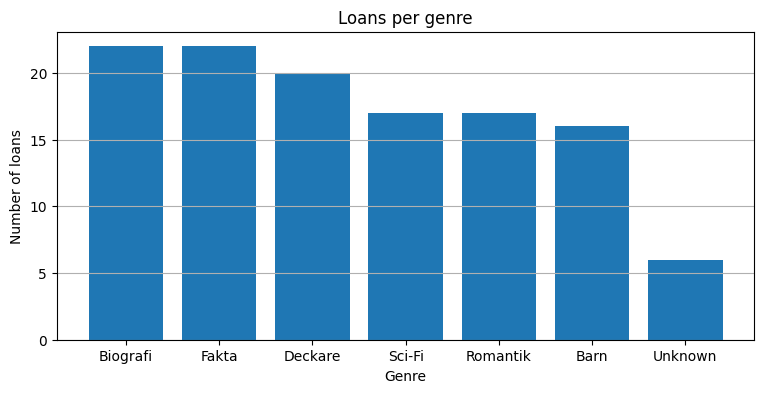

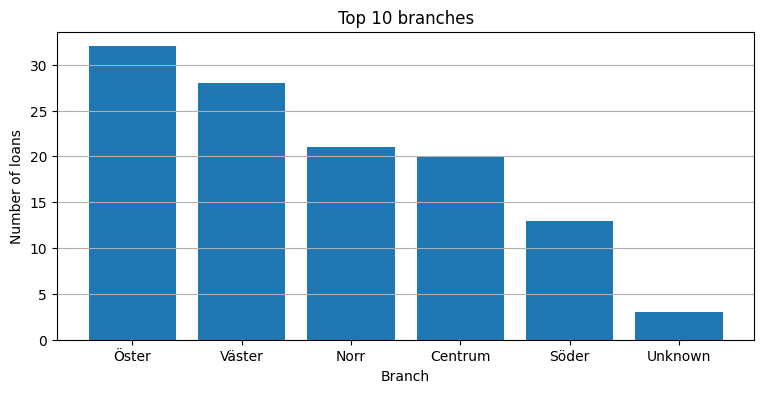

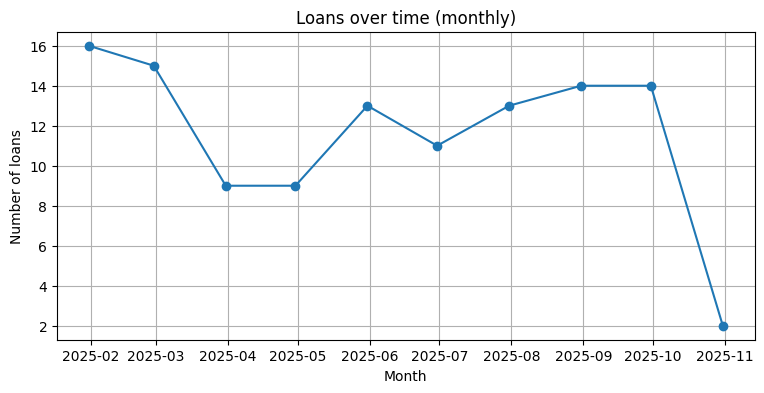

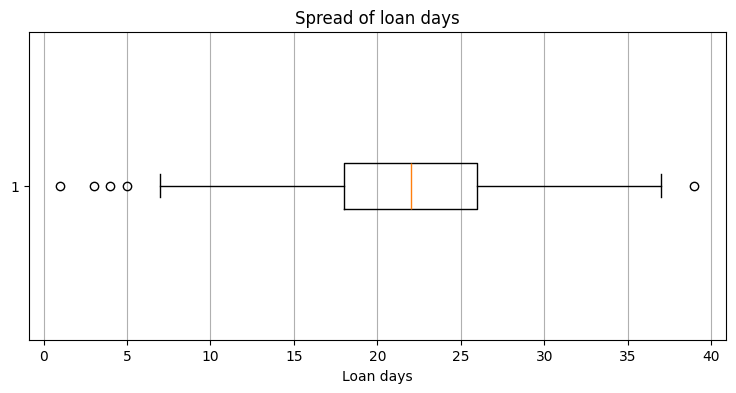

In [17]:
import matplotlib.pyplot as plt
from src import viz as V

# Loans per genre
fig, ax = plt.subplots(figsize=(9, 4))
V.bar(
	ax,
	by_genre["genre"],
	by_genre["loans"],
	"Loans per genre",
	"Genre",
	"Number of loans"
)
plt.savefig("images/fig_loans_per_genre.png", dpi=200)

# Top 10 branches
fig, ax = plt.subplots(figsize=(9, 4))
top_10 = by_branch.head(10)
V.bar(
	ax,
	top_10["branch"],
	top_10["loans"],
	"Top 10 branches",
	"Branch",
	"Number of loans"
)
plt.savefig("images/fig_top_10_branches.png", dpi=200)

# Loans per month
fig, ax = plt.subplots(figsize=(9, 4))
V.line(
	ax,
	ts_month["checkout_date"],
	ts_month["loans"],
	"Loans over time (monthly)",
	"Month",
	"Number of loans"
)
plt.savefig("images/fig_loans_per_month.png", dpi=200)

# Spread of loan time
fig, ax = plt.subplots(figsize=(9, 4))
V.box_h(
	ax,
	df["loan_days"],
	"Spread of loan days",
	"Loan days"
)
plt.savefig("images/fig_spread_of_loan_time.png", dpi=200)

In [18]:
import pandas as pd
piv = pd.pivot_table(
	df,
	index="branch",
	columns="genre",
	values="loan_id",
	aggfunc="nunique",
	fill_value=0,
	margins=True
)

piv.to_csv("data/pivot_branch_x_genre.csv")
piv.head()

genre,Barn,Biografi,Deckare,Fakta,Romantik,Sci-Fi,All
branch,,,,,,,
Centrum,3,3,3,3,2,4,17
Norr,4,5,3,5,2,3,21
Söder,2,3,3,2,2,1,13
Väster,6,4,4,8,6,1,28
Öster,1,7,6,4,5,7,30


In [19]:
M.top3_genres(df), M.top3_branches(df)

(      genre  loans
 0  Biografi     22
 1     Fakta     22
 2   Deckare     20,
    branch  loans
 0   Öster     32
 1  Väster     28
 2    Norr     21)

### Rekommendationer ###
- Stärk inköp av Biografi och Fakta-böcker. Har hög efterfrågan i flera filialer.
- Bemanna extra i Öster under månader med toppar.
- Följ upp övertidsandelen (nu 47.6%): förbättra påminnelser